# **Resolução de Problemas de Otimização sob Incerteza em Cadeias de Suprimentos através de Técnicas de Aprendizado por Reforço e Otimização Estocástica**

## **Iniciação Científca - CNPq**

### **Membros do Projeto**

* Julio César Alves

* Dilson Lucas Pereira

* Marcos Carvalho Ferreira


### Pip installs

In [1]:
%pip install tqdm
%pip install gymnasium
%pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk
%pip install tabulate
# %pip install git+https://github.com/ibm-cds-labs/pixiedust
# %pip install -e ./pixiedust

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/mimoralea/gym-walk to c:\users\user\appdata\local\temp\pip-install-anexzlws\gym-walk_1bb1c6ddd13945ba9f0bfcecd474c7b2
  Resolved https://github.com/mimoralea/gym-walk to commit 5999016267d6de2f5a63307fb00dfd63de319ac1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk 'C:\Users\User\AppData\Local\Temp\pip-install-anexzlws\gym-walk_1bb1c6ddd13945ba9f0bfcecd474c7b2'


Note: you may need to restart the kernel to use updated packages.


**Atenção**: após as instalações é recomendável **reiniciar o Kernel**. No VS Code, acesse a paleta de comandos (teclando `F1` OU `Ctrl+Shift+P`) e procurando a opção *Notebook: Restart Kernel* (dica: digite *kernel* na paleta para filtrar os comandos).

### Imports

In [2]:
#   Você pode usar a biblioteca externa do Python tqdm , para criar barras de progresso simples e sem complicações
# que você pode adicionar ao seu código e torná-lo mais animado!
from tqdm import tqdm

# Como implementar? --> Ex: "for e in tqdm(range(n_episodios), desc='Episodes for: ' + nome(string), leave=False):"

# tqdm("Intervalo desejado", "Descrição (desc)", "Leave" Se [padrão: True], mantém
# todos os traços da barra de progresso após o término da iteração):

import gymnasium as gym
import random
import gym_walk
import gym as old_gym
import numpy as np
from tabulate import tabulate

### Configurações

In [3]:
SEMENTES = (5, 80, 78, 27, 17)
# SEMENTES = (12, 34, 56, 78, 90) # usadas pelo autor do livro

### **Funções úteis**

* **Funções utilizadas nas estratégias:**

In [4]:
# Função utilizada para decair alfa e epsilon exponencialmente.
# Você dá um valor inicial, um valor mínimo e a porcentagem de max_iteracoes para decair os valores de inicial para mínimo.
def decaimento_exponencial(valor_ini, valor_min, taxa_decaimento, max_iteracoes, log_inicio=-2, log_base=10):
    # Índice onde o decaimento de valores termina e o valor_min vai até max_iteracoes.
    decaimento_iteracoes = int(max_iteracoes * taxa_decaimento)

    # Diferença entre o máximo de iterações e as iterações de decaimento
    iteracoes_remanescentes = max_iteracoes - decaimento_iteracoes

    # Usando o logspace para gerar uma escala logaritimica começando em log_start (padrão = -2), e terminando em 0. 
    # O número total de valores é decaimento_iteracoes e a base é log_base (padrão é 10). 
    # Perceba que está invertido com [::-1]!
    valor = np.logspace(log_inicio, 0, decaimento_iteracoes, base=log_base, endpoint=True)[::-1]

    # Os valores podem não terminar exatamente em 0, por causa do logaritmo
    # Alteramos para ficar entre 0 e 1 e assim a curva fica suave e bonita
    valor = (valor - valor.min()) / (valor.max() - valor.min())

    # Fazemos a transformação linear entre valor_ini e valor_min.
    valor = (valor_ini - valor_min) * valor + valor_min

    # E então enchemos um array com "valor", a função "pad" repete o valor mais à direita iteracoes_remanescentes número de vezes.
    valor = np.pad(valor, (0, iteracoes_remanescentes), 'edge')
    
    return valor

In [5]:
import itertools

# Função utilizada para criar uma trajetória necessária para o controle de Monte Carlo

# Esta versão do gerar_trajetoria é um pouco diferente. Agora precisamos levar em uma estratégia de seleção de ação, em vez de uma política gananciosa.

# Você passa a estratégia de seleção de ação, a função Q, o epsilon (Quão gancioso o agente vai ser?), o ambiente e a quantidade maxima de iterações 
# (caso o número de iterações ultrapasse este número a trajetória é retornada vazia (truncar)).
def gerar_trajetoria_epsilon_ganancioso(seleciona_acao, Q, epsilon, amb, max_iteracoes=200):
    # Criamos a variavel bolleana "terminado" que somente se tornará True quando o resultado da iteração levar a um estado terminal
    # Inicializamos o array que irá armazenar a trajetória (vazio)
    terminado, trajetoria = False, []

    # Loop principal
    while not terminado:
        # Resetamos o ambiente para garantir que ele esteja pronto para gerar a trajetória
        estado = amb.reset()

        # Entramos em loop infinito -> só para com break
        for t in itertools.count():
            # Selecionamos a acao para o estado atual de acordo com a estratégia passada
            acao = seleciona_acao(estado, Q, epsilon)

            # Realizamos uma iteração
            prox_estado, recompensa, terminado, _ = amb.step(acao)
            # Guardamos o resultado da iteração em um array
            experiencia = (estado, acao, recompensa, prox_estado, terminado)
            # append --> Acrescentamos a experiencia no final do array "trajetória"
            trajetoria.append(experiencia)

            # Para o loop quando chegamos em um estado terminal
            if terminado:
                break

            # Truncamos a trajetória quando atinje o máximo de iterações
            if t >= max_iteracoes - 1:
                trajetoria = []
                break

            # Passamos para o proximo estado
            estado = prox_estado
            
        return np.array(trajetoria, np.object)

* **Funções utilizadas para testes:**

In [6]:
def imprima_funcao_valor_de_estado(V, P, n_cols=4, prec=3, title='Função valor de estado:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def imprima_funcao_valor_de_acao(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Função Q (valor de ação):'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def imprima_politica(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [9]:
from itertools import cycle

def plotar_funcao_de_valor(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(valid_values.size, limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

## **Estratégias de aprendizagem por Reforço**

In [10]:
# Implementação do algoritmo de controle de Monte Carlo

# Você passa a política o ambiente para qual o algoritmo criará a política, desconto de recompensa, especificações para a criação do array de 
# decaimento exponencial de alpha e epsilon, número de episódios considerados, quantidade maxima de iterações e se utilizaremos a primeira 
# vista Monte Carlo ou não
def controle_mc(amb, gamma=1.0, ini_alpha=0.5, min_alpha=0.01, taxa_decay_alpha=0.5, ini_epsilon=1.0, min_epsilon=0.1, 
               taxa_decay_epsilon=0.9, n_episodios=3000, max_iteracoes=200, primeira_visita=True):
    # Obtemos o número de estados do ambiente (nS) e o número de ações disponíveis (nA)
    nS, nA = amb.observation_space.n, amb.action_space.n

    # Calculando todos os descontos possíveis de uma vez. 
    # Esta função logspace para uma gama de 0,99 e um max_step de 100 retorna um vetor de número 100: [1, 0,99, 0,9801, . . ., 0,3697].
    descontos = np.logspace(0, max_iteracoes, num=max_iteracoes, base=gamma, endpoint=False)
    # Usando a função criada anteriormente para criar o decaimento exponencial de alpha 
    alphas = decaimento_exponencial(ini_alpha, min_alpha, taxa_decay_alpha, n_episodios)
    # Usando a função criada anteriormente para criar o decaimento exponencial de epsilon 
    epsilons = decaimento_exponencial(ini_epsilon, min_epsilon, taxa_decay_epsilon, n_episodios)

    # Array utilizado para ver o progresso da avaliação da política
    pi_historico = []
    # Inicializando a função com as dimensões do ambiente analisado e os valores zerados
    Q = np.zeros((nS, nA), dtype=np.float64)
    # Array utilizado para ver o progresso da função Q a cada episodio
    Q_historico = np.zeros((n_episodios, nS, nA), dtype=np.float64)

    # Criando a estratégia de seleção de ação: Utilizamos Epsilon Ganancioso
    #     Funções anônimas (Lambda): são  funções que o usuário não precisa definir, ou seja, não vai precisar
    # escrever a função e depois utilizá-la dentro do código.
    seleciona_acao = lambda estado, Q, epsilon: \
        np.argmax(Q[estado]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[estado]))

    # Loop principal com tqdm
    # e --> Número da iteração
    for e in tqdm(range(n_episodios), leave=False):
        # Gerando a trajetória com a função criada anteriormente
        trajetoria = gerar_trajetoria_epsilon_ganancioso(seleciona_acao, Q, epsilons[e], amb, max_iteracoes)

        # Criamos o array que verifica se a trajetória passou pelo mesmo estado
        visitado = np.zeros((nS,nA), dtype=np.bool)

        # Loop secundário
        # t --> Número da iteração
        # (estado, acao, recompensa, _, _) --> Tupla de experiencia da trajetória
        for t, (estado, acao, recompensa, _, _) in enumerate(trajetoria):
            # Caso o estado já foi visitado e se estivermos usando a primeira visita MC
            if visitado[estado][acao] and primeira_visita:
                # Ignoramos tudo e vamos para a próxima iteração do loop
                continue

            # Marcamos que estado foi visitado
            visitado[estado][acao] = True

            # Descobrindo a quantidade de passos até o estado terminal
            n_passos = len(trajetoria[t:])
            # Calculando o Retorno: Somando todas recompensas (com seus respectivos descontos)
            G = np.sum(descontos[:n_passos] * trajetoria[t:, 2])
            # Atualizamos a Função Q (Aplicação da equação de Monte Carlo)
            Q[estado][acao] = Q[estado][acao] + alphas[e] * (G - Q[estado][acao])

        # Guardamos a Função Q atual no histórico
        Q_historico[e] = Q
        # Guardamos a política atual no histórico
        pi_historico.append(np.argmax(Q, axis=1))

    # Extraímos a Função de Valor de Estado selecionando as melhores ações de Q
    V = np.max(Q, axis=1)
    # Com a Função de Valor Feita podemos obter uma política ótima
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_historico, pi_historico

In [11]:
# Implementação do algoritmo SARSA

# Você passa a política o ambiente para qual o algoritmo criará a política, desconto de recompensa, especificações para a criação do array de 
# decaimento exponencial de alpha e epsilon, número de episódios considerados
def sarsa(amb, gamma=1.0, ini_alpha=0.5, min_alpha=0.01, taxa_decay_alpha=0.5, ini_epsilon=1.0, 
          min_epsilon=0.1, taxa_decay_epsilon=0.9, n_episodios=3000):
    # Obtemos o número de estados do ambiente (nS) e o número de ações disponíveis (nA)
    nS, nA = env.observation_space.n, env.action_space.n

    # Array utilizado para ver o progresso da avaliação da política
    pi_historico = []
    # Inicializando a função com as dimensões do ambiente analisado e os valores zerados
    Q = np.zeros((nS, nA), dtype=np.float64)
    # Array utilizado para ver o progresso da função Q a cada episodio
    Q_historico = np.zeros((n_episodios, nS, nA), dtype=np.float64)

    # Criando a estratégia de seleção de ação: Utilizamos Epsilon Ganancioso
    #     Funções anônimas (Lambda): são  funções que o usuário não precisa definir, ou seja, não vai precisar
    # escrever a função e depois utilizá-la dentro do código.
    seleciona_acao = lambda estado, Q, epsilon: \
        np.argmax(Q[estado]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[estado]))

    # Usando a função criada anteriormente para criar o decaimento exponencial de alpha 
    alphas = decaimento_exponencial(ini_alpha, min_alpha, taxa_decay_alpha, n_episodios)
    # Usando a função criada anteriormente para criar o decaimento exponencial de epsilon 
    epsilons = decaimento_exponencial(ini_epsilon, min_epsilon, taxa_decay_epsilon, n_episodios)

    # Loop principal com tqdm
    # e --> Número da iteração
    for e in tqdm(range(n_episodios), leave=False):
        # Resetamos o ambiente para garantir que ele esteja pronto para ser analisado
        # Obtemos o estado inicial e se o estado é terminal
        estado, terminado = amb.reset(), False
        # Selecionamos a acao para o estado atual de acordo com a estratégia passada
        acao = seleciona_acao(estado, Q, epsilons[e])
        
        # Loop secundário --> Só para se entrarmos em um estado terminal
        while not terminado:
            # Obtemos as informações de retorno do passo dado
            prox_estado, recompensa, terminado, _ = amb.step(acao)

            # Selecionamos a acao para o estado atual de acordo com a estratégia passada
            # Observe que antes de fazer qualquer cálculo, precisamos obter a ação para a próxima etapa.
            prox_acao = seleciona_acao(prox_estado, Q, epsilons[e])

            # Implementação da função TD: Calculando o objetivo (Caso o estado seja terminal temos que zerar)
            objetivo_td = recompensa + gamma * Q[prox_estado][prox_acao] * (not terminado)
            # Implementação da função TD: Calculando o erro
            erro_td = objetivo_td - Q[estado][acao]
            # Implementação da função TD: Calculando a função Q
            Q[estado][acao] = Q[estado][acao] + alphas[e] * erro_td

            # Passamos para o proximo estado e proxima ação
            estado, acao = prox_estado, prox_acao

        # Guardamos a Função Q atual no histórico
        Q_historico[e] = Q
        # Guardamos a política atual no histórico
        pi_historico.append(np.argmax(Q, axis=1))

    # Extraímos a Função de Valor de Estado selecionando as melhores ações de Q
    V = np.max(Q, axis=1)
    # Com a Função de Valor Feita podemos obter uma política ótima
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_historico, pi_historico

In [12]:
# Implementação do algoritmo Q-Learning

from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium.spaces.utils import flatdim

# Você passa a política o ambiente para qual o algoritmo criará a política, desconto de recompensa, especificações para a criação do array de 
# decaimento exponencial de alpha e epsilon, número de episódios considerados
def q_learning(amb, gamma=1.0, ini_alpha=0.5, min_alpha=0.01, taxa_decay_alpha=0.5, ini_epsilon=1.0, 
          min_epsilon=0.1, taxa_decay_epsilon=0.9, n_episodios=3000):
    # Obtemos o número de estados do ambiente (nS) e o número de ações disponíveis (nA)
    nS = flatdim(amb.observation_space) if isinstance(amb.observation_space, MultiDiscrete) else amb.observation_space.n
    # nA = flatdim(amb.action_space) if isinstance(amb.action_space, MultiDiscrete) else amb.action_space.n
    nA = flatdim(amb.action_space) if isinstance(amb.action_space, Discrete) else amb.action_space.n
    print(f"{nS=} {nA=}")

    # Array utilizado para ver o progresso da avaliação da política
    pi_historico = []
    # Inicializando a função com as dimensões do ambiente analisado e os valores zerados
    Q = np.zeros((nS, nA), dtype=np.float64)
    print(f'{Q.shape=}')
    # Array utilizado para ver o progresso da função Q a cada episodio
    Q_historico = np.zeros((n_episodios, nS, nA), dtype=np.float64)

    # Criando a estratégia de seleção de ação: Utilizamos Epsilon Ganancioso
    #     Funções anônimas (Lambda): são  funções que o usuário não precisa definir, ou seja, não vai precisar
    # escrever a função e depois utilizá-la dentro do código.
    seleciona_acao = lambda estado, Q, epsilon: \
        np.argmax(Q[estado]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[estado]))

    # Usando a função criada anteriormente para criar o decaimento exponencial de alpha 
    alphas = decaimento_exponencial(ini_alpha, min_alpha, taxa_decay_alpha, n_episodios)
    # Usando a função criada anteriormente para criar o decaimento exponencial de epsilon 
    epsilons = decaimento_exponencial(ini_epsilon, min_epsilon, taxa_decay_epsilon, n_episodios)

    # Loop principal com tqdm
    # e --> Número da iteração
    for e in tqdm(range(n_episodios), leave=False):
        print(f'{e=}')
        # Resetamos o ambiente para garantir que ele esteja pronto para ser analisado
        # Obtemos o estado inicial e se o estado é terminal
        estado, terminado = amb.reset(), False
        print(f'{terminado=}')
        # Loop secundário --> Só para se entrarmos em um estado terminal
        while not terminado:            
            # Selecionamos a acao para o estado atual de acordo com a estratégia passada
            acao = seleciona_acao(estado, Q, epsilons[e])
            print(f'ANTES: {estado=} {acao=} {Q[estado][acao]=}')
            # Obtemos as informações de retorno do passo dado
            prox_estado, recompensa, terminado, _ = amb.step(acao)
            print(f'{acao=} {prox_estado=} {recompensa=} {terminado=}')
            # Implementação da função Q-learning: Calculando o objetivo (Caso o estado seja terminal temos que zerar)
            objetivo_td = recompensa + gamma * Q[prox_estado].max() * (not terminado)
            # Implementação da função Q-learning: Calculando o erro
            erro_td = objetivo_td - Q[estado][acao]            
            # Implementação da função Q-learning: Calculando a Função Q
            Q[estado][acao] = Q[estado][acao] + alphas[e] * erro_td
            print(f'{objetivo_td=} {erro_td=} {Q[estado][acao]=}')

            # Passamos para o proximo estado
            estado = prox_estado      

        # Guardamos a Função Q atual no histórico
        Q_historico[e] = Q
        # Guardamos a política atual no histórico
        pi_historico.append(np.argmax(Q, axis=1))

    # Extraímos a Função de Valor de Estado selecionando as melhores ações de Q
    V = np.max(Q, axis=1)
    # Com a Função de Valor Feita podemos obter uma política ótima
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_historico, pi_historico

In [13]:
# Implementação do algoritmo Q-Learning duplo

# Você passa a política o ambiente para qual o algoritmo criará a política, desconto de recompensa, especificações para a criação do array de 
# decaimento exponencial de alpha e epsilon, número de episódios considerados
def double_q_learning(amb, gamma=1.0, ini_alpha=0.5, min_alpha=0.01, taxa_decay_alpha=0.5, ini_epsilon=1.0,
                      min_epsilon=0.1, taxa_decay_epsilon=0.9, n_episodios=3000):
    # Obtemos o número de estados do ambiente (nS) e o número de ações disponíveis (nA)
    nS, nA = amb.observation_space.n, amb.action_space.n
    
    # Array utilizado para ver o progresso da avaliação da política
    pi_historico = []

     # Inicializando a função Q1 e Q2 com as dimensões do ambiente analisado e os valores zerados
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    # Arrays utilizados para ver o progresso da funções Q1 e Q2 a cada episodio
    Q1_historico = np.zeros((n_episodios, nS, nA), dtype=np.float64)
    Q2_historico = np.zeros((n_episodios, nS, nA), dtype=np.float64)

    # Criando a estratégia de seleção de ação: Utilizamos Epsilon Ganancioso
    #     Funções anônimas (Lambda): são  funções que o usuário não precisa definir, ou seja, não vai precisar
    # escrever a função e depois utilizá-la dentro do código.
    seleciona_acao = lambda estado, Q, epsilon: \
        np.argmax(Q[estado]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[estado]))

    # Usando a função criada anteriormente para criar o decaimento exponencial de alpha 
    alphas = decaimento_exponencial(ini_alpha, min_alpha, taxa_decay_alpha, n_episodios)
    # Usando a função criada anteriormente para criar o decaimento exponencial de epsilon 
    epsilons = decaimento_exponencial(ini_epsilon, min_epsilon, taxa_decay_epsilon, n_episodios)

    # Loop principal com tqdm
    # e --> Número da iteração
    for e in tqdm(range(n_episodios), leave=False):
        # Resetamos o ambiente para garantir que ele esteja pronto para ser analisado
        # Obtemos o estado inicial e se o estado é terminal
        estado, terminado = amb.reset(), False

        # Loop secundário --> Só para se entrarmos em um estado terminal
        while not terminado:
            # Selecionamos a acao para o estado atual de acordo com a estratégia passada
            # Precisamos passar somente uma função Q por isso criamos um array com a média de nossas duas funções Q
            # Também poderíamos usar a soma de nossas funções Q aqui, eles darão resultados semelhantes.
            acao = seleciona_acao(estado, (Q1 + Q2)/2., epsilons[e])

            # Obtemos as informações de retorno do passo dado
            prox_estado, recompensa, terminado, _ = amb.step(acao)

            # Escolhemos aleatoriamente (50%) qual função Q usar
            if np.random.randint(2):
                # Vamos usar a ação que Q1 acha melhor
                argmax_Q1 = np.argmax(Q1[prox_estado])

                # Mas usamos o valor de Q2 para calcular o objetivo TD
                objetivo_td = recompensa + gamma * Q2[prox_estado][argmax_Q1] * (not terminado)
                # Resto da implementação da função do Q-learning: Usando Q1
                erro_td = objetivo_td - Q1[estado][acao]
                Q1[estado][acao] = Q1[estado][acao] + alphas[e] * erro_td

            else:
                # Vamos usar a ação que Q2 acha melhor
                argmax_Q2 = np.argmax(Q2[prox_estado])

                # Mas usamos o valor de Q1 para calcular o objetivo TD
                objetivo_td = recompensa + gamma * Q1[prox_estado][argmax_Q2] * (not terminado)
                # Resto da implementação da função do Q-learning: Usando Q2
                erro_td = objetivo_td - Q2[estado][acao]
                Q2[estado][acao] = Q2[estado][acao] + alphas[e] * erro_td

            # Passamos para o proximo estado
            estado = prox_estado

        # Guardamos as Funções Q1 e Q2 atuais no histórico
        Q1_historico[e] = Q1
        Q2_historico[e] = Q2
        # Guardamos a política atual no histórico, perceba que utilizaremos a avaliação média entre Q1 e Q2
        pi_historico.append(np.argmax((Q1 + Q2)/2., axis=1))

    # O Q final é média do 1 com o 2
    Q = (Q1 + Q2)/2.
    # Obtemos a Função valor estado
    V = np.max(Q, axis=1)
    # Obtemos uma política ótima
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    # Perceba que retornamos o histórico médio de Q
    return Q, V, pi, (Q1_historico + Q2_historico)/2., pi_historico

## **Implementação de Ambientes customizados**

In [14]:
import gymnasium as gym
from gymnasium import spaces
from typing import Any, Optional
from collections import deque

class BeerGame(gym.Env):

    # Método 'construtor'
    def __init__(self, seed : Optional[int] = None) -> None: 
       # 1-> Definindo o espaço de ações 
       self.pedido_max = 20 # Podem ser pedidos somente 20 cervejas por vez
       self.pedido_min = 0 # Não é possível realizar pedidos negativos (Isso não faz sentido!!)
       self.pedido_ini = 4 # O pedido inicial sempre é 4
       self.pedido_ant = self.pedido_ini # Essa variável 'pedido_ant' é uma variável auxiliar que guarda a informação sobre o pedido feito anteriormente (será atualizada a cada iteração)
       # Declarando espaço de ações:
       self.action_space = spaces.MultiDiscrete(np.array(4*[self.pedido_max]))
       
       # 2-> Definindo uma seed
       self.seed(seed) # Chamamos o método que cria uma seed
       
       # 3-> Definindo o espaço de estados
       self.estoque_ini = 12 # A quantidade inicial em estoque sempre é 12
       self.transporte_ini = 4 # A quantidade inicial em transporte sempre é 4
       self.capacidade_max = 500 # A capacidade máxima de estoque em qualquer um dos membros da cadeia de suprimentos é 500 
       self.capacidade_min = 0 # Não é possível realizar guardar uma quantidade de cerveja negativa (Isso não faz sentido!!)
       # Definindo o observation space: limites, tipo de espaço e forma
       self.observation_space = spaces.MultiDiscrete(np.array(12*[self.capacidade_max]+[self.pedido_max]))

       # 4-> Inicializando os arrays dos estoques, transporte e produção
       self.estoques = 4*[0] # Simples 4 vetores de 1 posição uma para cada (R, W, D, F)
       self.entrega_retailer = deque(2*[0]) # Fila com 2 posições Retailer - Transporte
       self.entrega_wholesailer = deque(2*[0]) # Fila com 2 posições Wholesaler - Transporte
       self.entrega_distributor = deque(2*[0]) # Fila com 2 posições Distributor - Transporte
       self.producao_factory = deque(2*[0]) # Fila com 2 posições Factory - Produção
       
       # 5-> Definimos os arrays com os valores iniciais correspondentes
       self._inicializar_cadeia()
       
       # 6-> Definimos os preços 
       self.custo_de_estoque = 0.5
       self.custo_de_backlog = 1
       
       # 6-> Definimos o oeríodo em que o BeerGame será rodado
       self.periodo_max = 50
       self.periodo_atual = 0 # Variável auxiliar será atualizada a cada iteração

    # Define os arrays com os valores iniciais correspondentes
    def _inicializar_cadeia(self) -> None:
       self.estoques = 4*[self.estoque_ini] # Estoques começam com 12 cervejas
       self.entrega_retailer = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.entrega_wholesaler = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.entrega_distributor = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.producao_factory = deque(2*[self.transporte_ini]) # Estão produzindo 4 cervejas em cada slot de produção

    #   Esse método retorna um estado, ou seja, uma observação do estado, em que a 
    # posição 0 é estoque do Retailer e a posicao 11 é slot de producao da fábrica
    # a posição 12 é na verdade a informação sobre o pedido feito ao Retailer anteriormente
    def _montar_estado(self) -> list[int]:
       estado = 13*[0]
       estado[0] = self.estoques[0]
       estado[1] = self.entrega_retailer[0]
       estado[2] = self.entrega_retailer[1]
       estado[3] = self.estoques[1]
       estado[4] = self.entrega_wholesaler[0]
       estado[5] = self.entrega_wholesaler[1]
       estado[6] = self.estoques[2]
       estado[7] = self.entrega_distributor[0]
       estado[8] = self.entrega_distributor[1]
       estado[9] = self.estoques[3]
       estado[10] = self.producao_factory[0]
       estado[11] = self.producao_factory[1]
       estado[12] = self.pedido_ant
       return estado

    # Esse método reseta o ambiente, reinicializando os arrays com os valores iniciais definidos no 'construtor'
    def reset(self) -> list[int]:
       self._inicializar_cadeia() # Reinicializa os arrays com os valores iniciais
       self.periodo_atual = 0 # Reinicia a contagem do período
       return np.array(self._montar_estado()) # retorna uma observação do estado inicial
    
    # Esse método executa a ação escolhida no ambiente e retorna uma observação do estado, recompensa, se o estado é terminal e uma informação
    def step(self, action : list[int]) -> tuple[list[int], float, bool, bool, dict]:
       self.periodo_atual += 1 # Cada vez que uma ação é tomada é considerado um novo período
       
       recompensa = 0 # Inicializamos o valor da recompensa
       self.pedido_ant = self.rand_generator.randint(self.pedido_max + 1) # Sorteamos um número (de 1 a 20) que será o número de cervejas solicitados pelo cliente ao Retailer
       
       # Chegaram os caminhões: Os pedidos feitos anteriormente que estavam aguardando nas filas de entrega é adicionado aos estoques
       self.estoques[0] += self.entrega_retailer.popleft()
       self.estoques[1] += self.entrega_wholesaler.popleft()
       self.estoques[2] += self.entrega_distributor.popleft()
       self.estoques[3] += self.producao_factory.popleft()
       
       # Decisão Retailer:
       if (self.estoques[0] >= self.pedido_ant):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[0] = self.estoques[0] - self.pedido_ant
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         recompensa += (self.pedido_ant - self.estoques[0])*self.custo_de_backlog 
         self.estoques[0] = 0 # E o estoque é zerado
       
       # Decisão Wholesaler:
       if (self.estoques[1] >= action[0]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[1] = self.estoques[1] - action[0]
         # Como Wholesaler não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_retailer.append(action[0])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         recompensa += (action[0] - self.estoques[1])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_retailer.append(self.estoques[1])
         self.estoques[1] = 0 # E o estoque é zerado

       # Decisão Distributor:
       if (self.estoques[2] >= action[1]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[2] = self.estoques[2] - action[1]
         # Como Distributor não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_wholesaler.append(action[1])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         recompensa += (action[1] - self.estoques[2])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_wholesaler.append(self.estoques[2])
         self.estoques[2] = 0 # E o estoque é zerado
       
       # Decisão Factory:
       if (self.estoques[3] >= action[2]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[3] = self.estoques[3] - action[2]
         # Como Factory não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_distributor.append(action[2])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         recompensa += (action[2] - self.estoques[3])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_distributor.append(self.estoques[3])
         self.estoques[3] = 0 # E o estoque é zerado
       
       # Da início a produção do número de unidades pedidas a fábrica
       self.producao_factory.append(action[3])
       
       # Além dos custos de Backlog é adicionado o custo de estoque por cada unidade em estoque em (R, W, D, F) -> Perceba que nessa situação a recompensa é negativa
       recompensa += sum(self.estoques)*self.custo_de_estoque
       # BeerGame só termina quando é atinjido o 50º período
       terminado = self.periodo_atual == self.periodo_max

       return np.array(self._montar_estado()), recompensa, terminado, {} # Retorna-se a observação do estado, a recompensa, se é estado terminal  

    # Esse método imprime uma observação do estado
    def render(self, mode : str ="human") -> Any: # opcional
       print(self._montar_estado())

    # Esse método close fecha todos os recursos abertos que foram usados pelo ambiente. No nosso caso não foi preciso implementá-lo
    def close(self) -> None: # opcional
       pass
    
    #   Cria uma seed aleatória para iteração: afeta diretamente os pedidos aleatórios do suposto cliente
    # Dessa forma a seed é utilizada quando deseja repetir um certo cenário no ambiente e testá-lo de diferentes formas
    def seed(self, seed=None) -> None:
      self.rand_generator = np.random.RandomState(seed)
      self.action_space.seed(seed)

In [15]:
class BeerGameSimplificado(BeerGame):
  
  def __init__(self,  seed : Optional[int] = None) -> None:
        super().__init__()
        
        # Reescrevendo a variável 'action_space' para aceitar somente 1 ação:
        self.action_space = spaces.Discrete(20)

  def step(self, action : int) -> tuple[list[int], float, bool, bool, dict]:
        # Recebe uma única ação e cria uma lista com a ação replicada para então chamar o método da Classe Pai
        acao = [action, action, action, action]
        
        return super().step(acao)

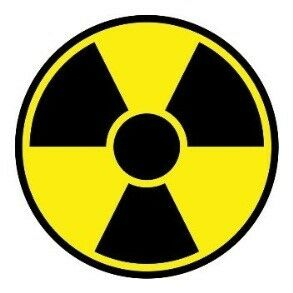
## **Área de Testes**

### **Como debugar no Google Colab?**
* https://stackoverflow.com/questions/52656692/debugging-in-google-colabo-google-colab-94582

Command  Description

* list     Show the current location in the file
* h(elp)   Show a list of commands, or find help on a specific command
* q(uit)   Quit the debugger and the program
* c(ontinue)  Quit the debugger, continue in the program
* n(ext)   Go to the next step of the program
* <enter>  Repeat the previous command
* p(rint)  Print variables
* s(tep)   Step into a subroutine
* r(eturn)    Return out of a subroutine

### **Pixie_debugger -> Problema com versão do jinja2**

In [16]:
beer_game : BeerGameSimplificado = BeerGameSimplificado(seed=10)

estado : list[int] = beer_game.reset()
print(f'estado inicial {estado}')


Q, V, pi, Q_historico, pi_historico = q_learning(beer_game, n_episodios=2)

print(f'Q = {Q}')
print(f'V = {V}')
print(f'pi = {pi}')


C:\Users\User\AppData\Local\Temp\ipykernel_10672\2698045853.py:17: RuntimeWarning: invalid value encountered in true_divide
  valor = (valor - valor.min()) / (valor.max() - valor.min())


estado inicial [12  4  4 12  4  4 12  4  4 12  4  4  4]
nS=6020 nA=20
Q.shape=(6020, 20)


e=0
terminado=False
ANTES: estado=array([12,  4,  4, 12,  4,  4, 12,  4,  4, 12,  4,  4,  4]) acao=10 Q[estado][acao]=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
acao=10 prox_estado=array([15,  4, 10,  6,  4, 10,  6,  4, 10,  6,  4, 10,  1]) recompensa=16.5 terminado=False
objetivo_td=16.5 erro_td=array([16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5,
       16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5]) Q[estado][acao]=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
ANTES: estado=array([15,  4, 10,  6,  4, 10,  6,  4, 10,  6,  4, 10,  1]) acao=12 Q[estado][acao]=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
acao=12 prox_estado=array([15, 10, 10,  0, 10, 10,  0, 10, 10,  0, 10, 12,  4]) recompensa=13.5 terminado=False
objetivo_td=13.5 erro_td=array([13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5,
 